In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU availability
device = torch.device("cuda:0")
print("Using device:", device)

Using device: cuda:0


In [2]:
# Constants
MAX_NUMBER = 1e8
N = 10000
BATCH_SIZE = 1000
A = 10005000
A_MAX = 10000
MIN_A = 2
MAX_EPOCHS = 250
NUM_A = 5

In [3]:
# Neural network definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 640)
        self.fc2 = nn.Linear(640, 1280)
        self.fc3 = nn.Linear(1280, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
# Dataset creation function
def create_dataset(N, a):
    M = MAX_NUMBER / A_MAX
    x = np.random.uniform(0, 1, N)
    fraction_ax = np.modf(a * x)[0]
    fraction_ax = np.where(fraction_ax > 0, fraction_ax, 1 + fraction_ax)
    return np.vstack((x, fraction_ax)).T

In [4]:
# Training function
def train_model(N, A, max_epochs=MAX_EPOCHS, num_a=NUM_A):
    a_values = np.random.randint(1, A, num_a)
    train_loss = np.zeros(max_epochs)
    test_loss = np.zeros(max_epochs)

    for a in a_values:
        dataset = create_dataset(N, a)
        dataset_test = create_dataset(1000, a)
        train_data = TensorDataset(torch.Tensor(dataset[:, 0]), torch.Tensor(dataset[:, 1]))
        train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
        test_data = TensorDataset(torch.Tensor(dataset_test[:, 0]), torch.Tensor(dataset_test[:, 1]))
        test_loader = DataLoader(test_data, batch_size=1000, shuffle=True)

        net = Net().to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        for epoch in range(max_epochs):
            for x, y in train_loader:
                x, y = x.to(device).view(-1, 1), y.to(device).view(-1, 1)
                optimizer.zero_grad()
                loss = criterion(net(x), y)
                loss.backward()
                optimizer.step()
                train_loss[epoch] += loss.item()

            for x, y in test_loader:
                x, y = x.to(device).view(-1, 1), y.to(device).view(-1, 1)
                loss = criterion(net(x), y)
            test_loss[epoch] += loss.item()
    return train_loss*BATCH_SIZE/(num_a*N), test_loss / num_a

In [5]:
# Main script
a_range = np.logspace(np.log10(MIN_A), np.log10(A_MAX), num=10, base=10).astype(int)
train_losses = []
test_losses = []

for A in tqdm(a_range):
    losses = train_model(N, A)
    train_losses.append(losses[0])
    test_losses.append(losses[1])

100%|██████████| 10/10 [14:58<00:00, 89.89s/it]


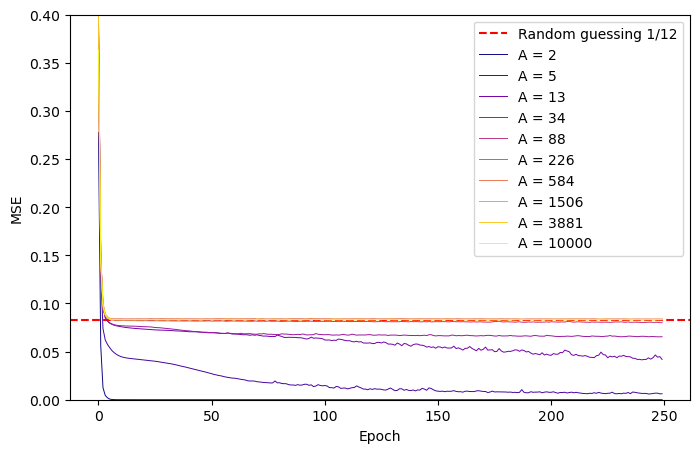

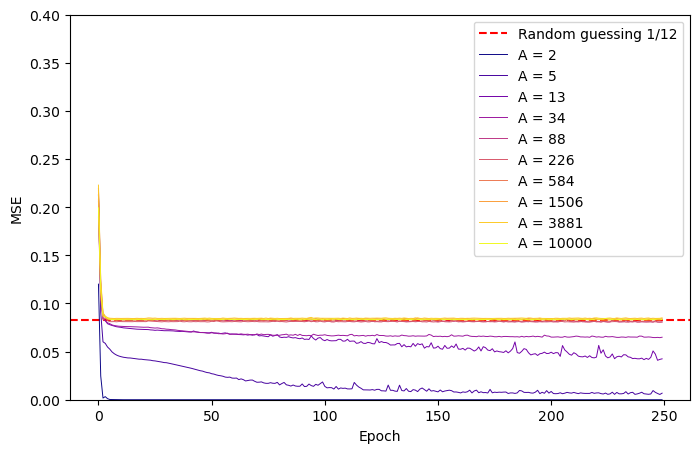

In [6]:
# Plotting training losses
plt.figure(figsize=(8, 5))
colors = cm.plasma(np.linspace(0, 1, len(a_range)))
plt.axhline(y=1/12, color='r', linestyle='--', label='Random guessing 1/12')

for i, A in enumerate(a_range):
    plt.plot(train_losses[i], linewidth=0.7, color=colors[i], label=f'A = {A}')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.4)
plt.legend()
plt.savefig('train_loss.png', dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 5))
colors = cm.plasma(np.linspace(0, 1, len(a_range)))
plt.axhline(y=1/12, color='r', linestyle='--', label='Random guessing 1/12')

for i, A in enumerate(a_range):
    plt.plot(test_losses[i], linewidth=0.7, color=colors[i], label=f'A = {A}')

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0, 0.4)
plt.legend()
plt.savefig('test_loss.png', dpi=400, bbox_inches='tight')
plt.show()